![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Analyzing Monthly Temperature Data to Detect Extreme Events

Production date: 16-Dec-2024

Produced by: Camila Trigoso (VUB)

## 🌍 Use case: Monthly temperature anomalies to detect extreme temperature events

## ❓ Quality assessment question
 **Can ERA5-Land monthly averaged data effectively detect specific extreme temperature events documented in the literature?**

[ERA5-Land monthly averaged data (1950–present)](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview) is a reanalysis dataset available from the Climate Data Store (CDS). It features a regular spatial resolution on a latitude/longitude grid of 0.1° x 0.1° (native resolution: 9 km). The dataset provides monthly averaged and hourly averaged by month data for various parameters. It includes 31 instantaneous parameters, one of which is the 2-meter air temperature, often called air temperature. This parameter is particularly valuable for climate monitoring, including the tracking of extreme temperature events such as heatwaves [[1]](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation).

The goal of this quality assessment is to evaluate whether the ERA5-Land dataset can effectively detect specific extreme temperature events documented in literature. As a case study, we chose the July 2022 heatwave in the United States. It was analyzed by comparing ERA5-Land data to the National Oceanic and Atmospheric Administration's (NOAA) Monthly National Analysis [[2]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202207). Although the heatwave spanned multiple months, July was chosen for this analysis to maintain focus and brevity, particularly as Texas recorded notable temperature extremes during this period.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The ERA5-Land dataset can effectively detect extreme temperature anomalies in specific regions when compared to a baseline period.
* Discrepancies between ERA5-Land and NOAA information where found for the case study of July 2022 in the USA. However, these differences were relatively small and can be expacted because different modells were used. 
* ERA5-Land allows for easy analysis of temperature anomalies over long periods of time for any chosen area worldwide, making it a versatile tool for global climate studies.
```

## 📋 Methodology

The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](reanalysis_reanalysis-era5-land-monthly-means_extremes-detection_q02:section-1)**
 * Download the monthly averaged 2 meter temperature from the reanalysis-era5-land-monthly-means dataset for the period from 1961 to 2024. Choose the area encompassing the contiguous United States.

**[](reanalysis_reanalysis-era5-land-monthly-means_extremes-detection_q02:section-2)**
 * Calculate the temperature anomalies for July 2022 compared to the average July temperature for the baseline period 1991-2020.
 * Plot the anomalies on a map of the contiguous United States.
 * Calculate the anomalies for an area in which the results of the previous map differ from those of a reference source (NOAA).
 * Analyze the results for this area over time.

**[](reanalysis_reanalysis-era5-land-monthly-means_extremes-detection_q02:section-3)**
 * Calculate and plot the temperature anomalies for the month of July for the state of Texas (average for the whole state) over time.
 * Compare the value for 2022 with the literature.

## 📈 Analysis and results

(reanalysis_reanalysis-era5-land-monthly-means_extremes-detection_q02:section-1)=
### 1. Request and download data

#### Import packages

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import pymannkendall as mk
import shapely.geometry
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/trigoso_camila/.cdsapirc")
plt.style.use("seaborn-v0_8-notebook")

#### Set the data request

In [6]:
year_start = 1961  # Example start year
year_stop = 2024   # Example stop year

# Adjust the months for 2024
months_2024 = [f"{month:02d}" for month in range(1, 11)]  # Months 1-10 for 2024
months_other_years = [f"{month:02d}" for month in range(1, 13)]  # Full months (1-12) for other years

collection_id = "reanalysis-era5-land-monthly-means"

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": "2m_temperature",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [],
    "time": "00:00",
    "data_format": "grib",
    "download_format": "zip",
    "area": [49, -125, 24, -66],
}

# Adjust months for the request
for year in range(year_start, year_stop + 1):
    if year == 2024:
        request["month"].extend(months_2024)
    else:
        request["month"].extend(months_other_years)

#### Download data

In [7]:
ds = download.download_and_transform(collection_id, request, chunks={"year": 1})

100%|██████████| 64/64 [00:01<00:00, 48.75it/s]


Convert temperature to °F.

In [8]:
da = ds["t2m"]
with xr.set_options(keep_attrs=True):
    da = (da - 273.15) * 9/5 + 32  # Convert Kelvin to Fahrenheit
da.attrs["units"] = "°F"

(reanalysis_reanalysis-era5-land-monthly-means_extremes-detection_q02:section-2)=
### 2. Temperature anomalies nationwide

Clip data to the contiguous USA area.

In [9]:
#Clip to USA
def clip_shapefile(data, shapefile_path):

    shapefile_crs = "EPSG:4326"  # Ensure the CRS matches the raster data
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path).to_crs(shapefile_crs)

    # Set CRS and spatial dimensions for the data
    data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    data = data.rio.write_crs(shapefile_crs)

    # Clip the data using the shapefile geometry
    data_clip = data.rio.clip(
        gdf.geometry.apply(shapely.geometry.mapping), gdf.crs, drop=False
    )
    return data_clip

# Example usage
shapefile_path = "/data/wp5/trigoso_camila/ERA5land/US_states/usa.shp" #Obtained from the US Census Bureau
da_clipped = clip_shapefile(da, shapefile_path)

#### Calculation

Calculate temperature anomalies for July 2022 in relation to the baseline 1991-2020.

In [31]:
# Extract July 2022
da_july_2022 = da_clipped.sel(forecast_reference_time="2022-07-01")

# Baseline calculation 
def compute_time_weighted_mean(da, month, start_year, end_year):
    
    # Filter the data by the specified month and year range
    da_filtered = da.sel(
        forecast_reference_time=da.forecast_reference_time.where(
            (da.forecast_reference_time.dt.month == month) &
            (da.forecast_reference_time.dt.year >= start_year) &
            (da.forecast_reference_time.dt.year <= end_year),
            drop=True
        )
    )
    return da_filtered

# Baseline 1991-2020
da_baseline_91_20 = compute_time_weighted_mean(da_clipped, 7, 1991, 2020)
da_baseline_91_20_mean = diagnostics.time_weighted_mean(da_baseline_91_20)
# Anomalies calculation
da_anomalies_91_20 = da_july_2022 - da_baseline_91_20_mean

#### Plot anomalies nationwide

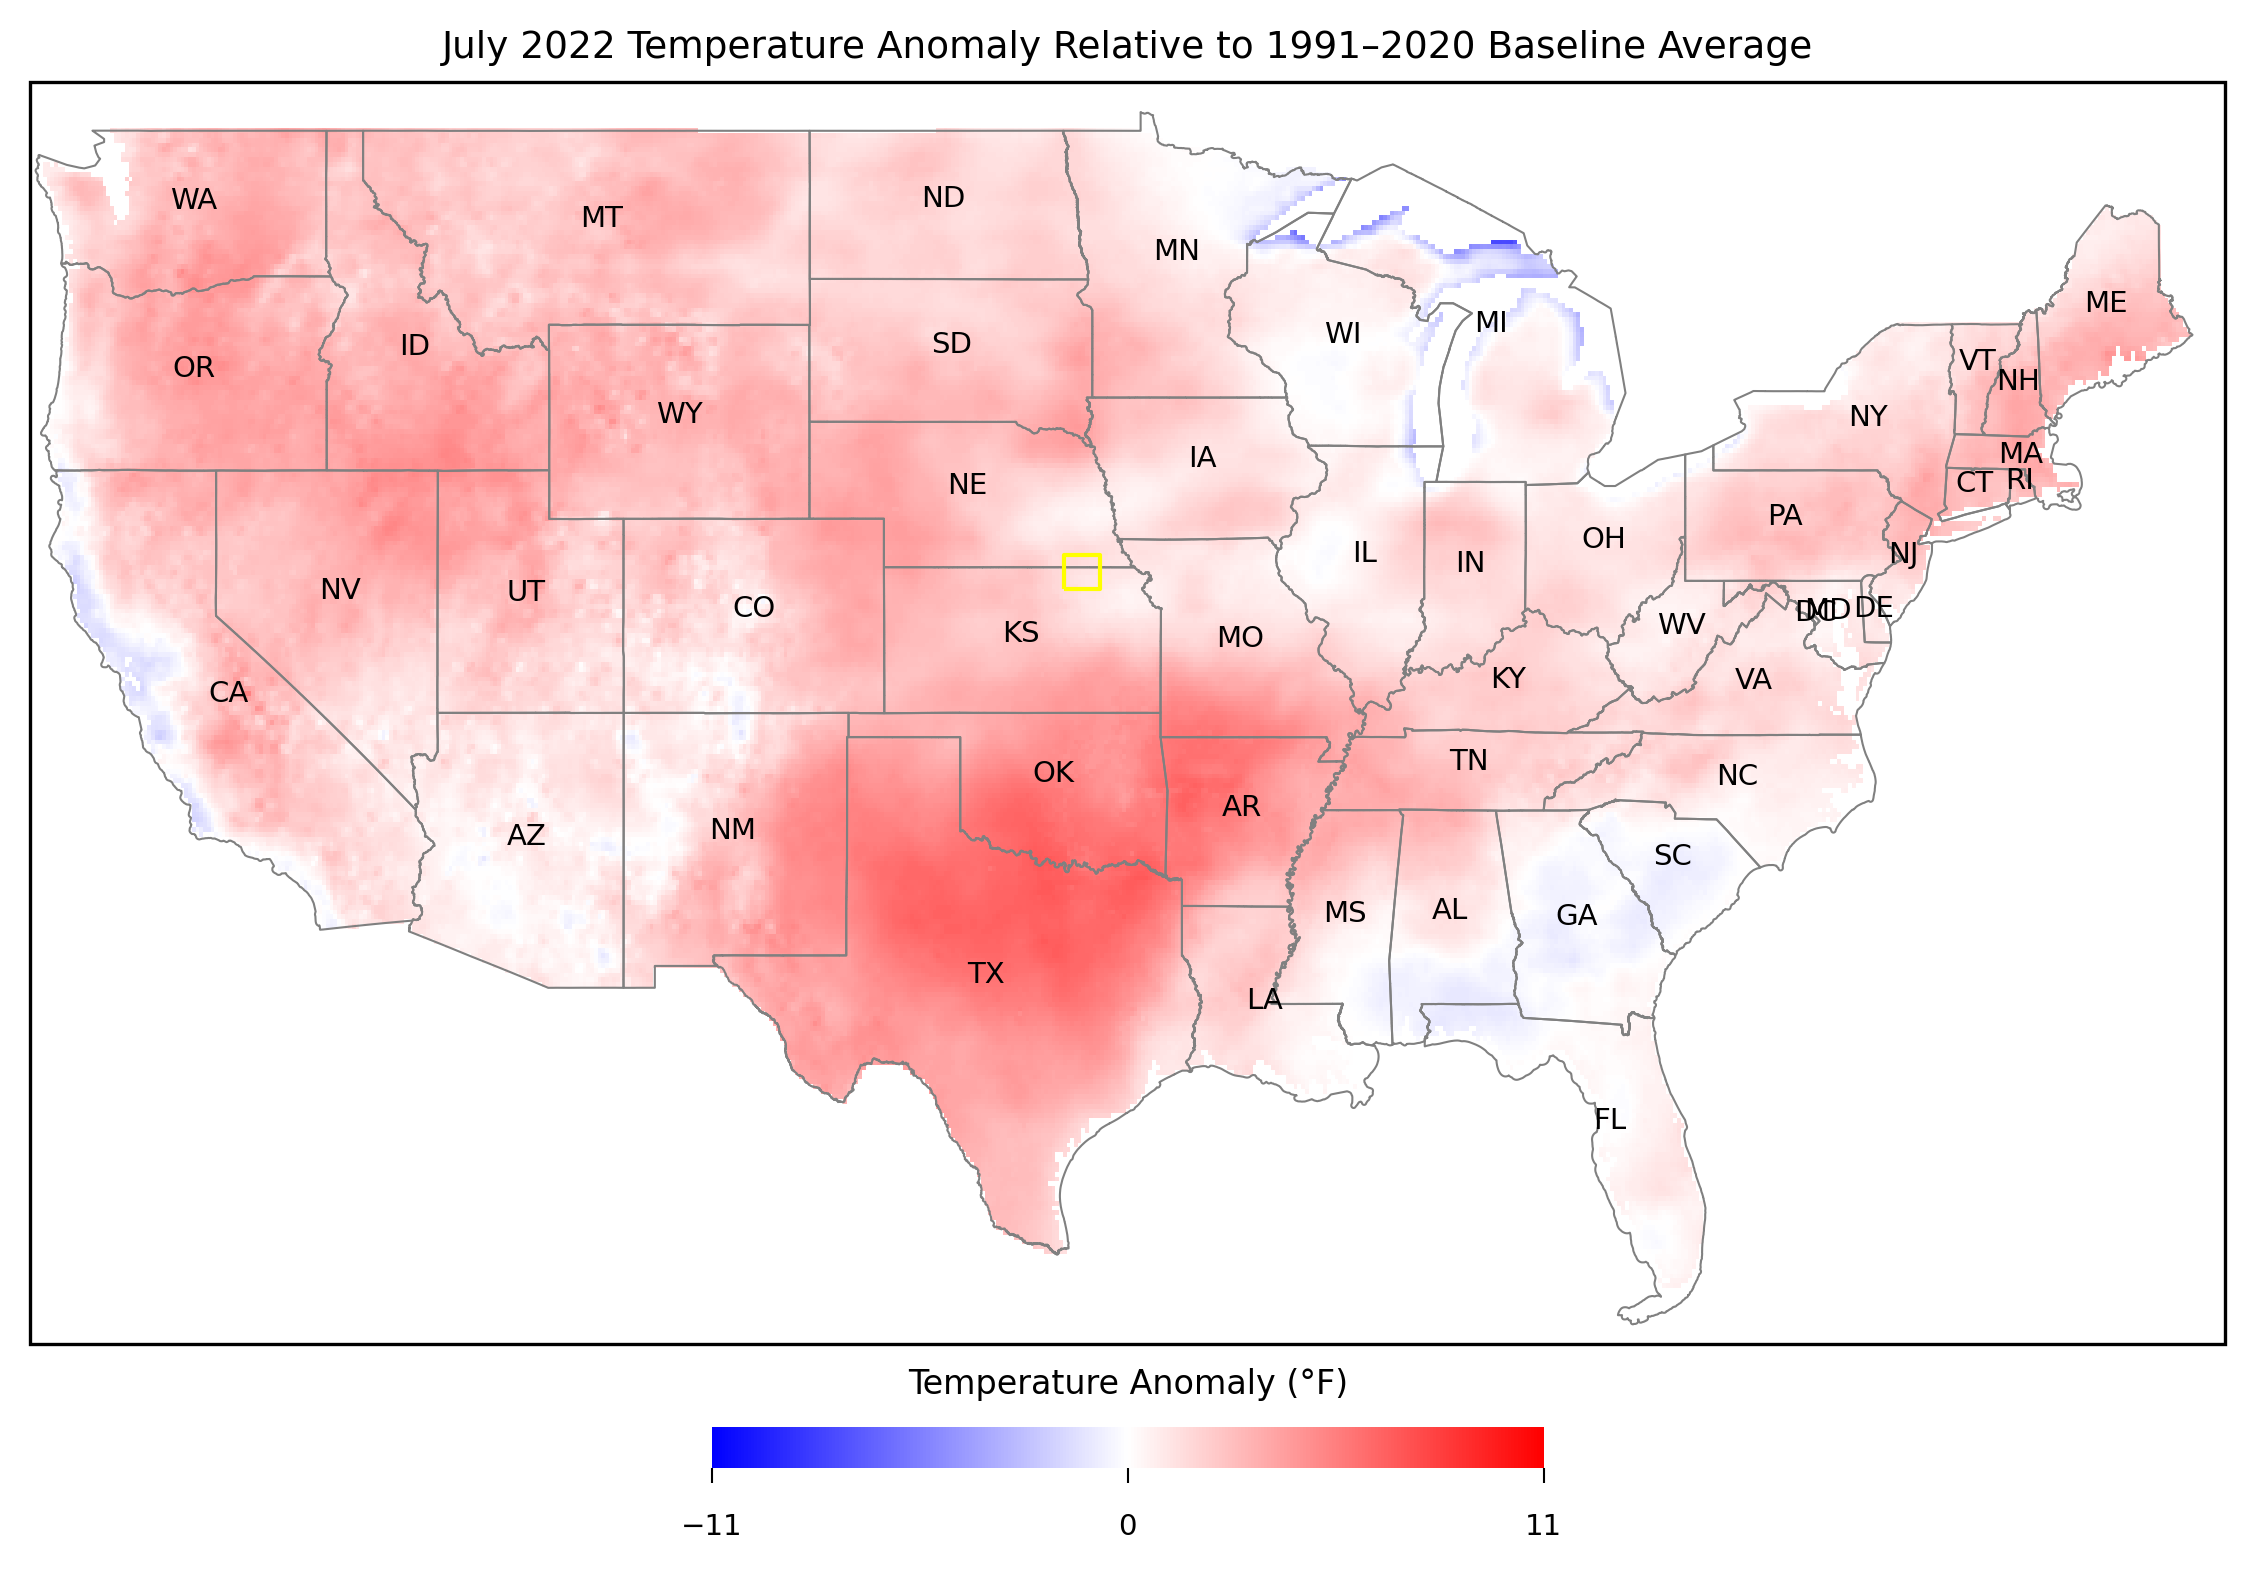

In [75]:
# Shapefile of states
shapefile_path = "/data/wp5/trigoso_camila/ERA5land/US_states/usa48.shp"  # Obtained from the US Census Bureau
gdf = gpd.read_file(shapefile_path)

# Define the rectangular ROI coordinates (minimum and maximum latitudes and longitudes)
min_lon, min_lat = -97.21110, 39.56304  # Bottom-left corner
max_lon, max_lat = -96.23873, 40.25180  # Top-right corner

# Create a rectangle using the coordinates (define corners)
roi_coords = [
    (min_lon, min_lat),  # Bottom-left corner
    (min_lon, max_lat),  # Top-left corner
    (max_lon, max_lat),  # Top-right corner
    (max_lon, min_lat),  # Bottom-right corner
    (min_lon, min_lat)   # Closing the polygon
]

# Create a Polygon from the coordinates
roi_polygon = shapely.geometry.Polygon(roi_coords)

# Create a GeoDataFrame for the ROI
roi_gdf = gpd.GeoDataFrame({"geometry": [roi_polygon]}, crs="EPSG:4326")

# Update the plot with the converted data
fig, ax = plt.subplots(figsize=(10, 6), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Fahrenheit temperature anomalies
temperature_plot = da_anomalies_91_20.plot.imshow(
    ax=ax, cmap='bwr', add_colorbar=False, vmin=-11, vmax=11
)

# Set the extent to focus on the USA
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Plot the shapefile (state borders)
gdf.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5, transform=ccrs.PlateCarree())

# Add labels for each state from the 'STUSPS' column
for _, row in gdf.iterrows():
    state_geom = row['geometry']
    state_centroid = state_geom.centroid
    state_name = row['STUSPS']
    ax.text(state_centroid.x, state_centroid.y, state_name,
            fontsize=7, ha='center', transform=ccrs.PlateCarree())

# Plot the ROI on top of the temperature anomalies map
roi_gdf.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=1, transform=ccrs.PlateCarree())

# Add title and labels
ax.set_title("July 2022 Temperature Anomaly Relative to 1991–2020 Baseline Average", fontsize=9)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Customize the colorbar
cbar = plt.colorbar(temperature_plot, ax=ax, orientation='horizontal', fraction=0.03, pad=0.06)
cbar.set_label('Temperature Anomaly (°F)', fontsize=8, rotation=0, labelpad=8)
cbar.outline.set_visible(False)
cbar.ax.tick_params(width=0.5)

# Set colorbar ticks in Fahrenheit
cbar.set_ticks([-11, 0, 11])
cbar.ax.tick_params(labelsize=7)
cbar.ax.xaxis.set_label_position('top')

# Show the plot
plt.show()

##### Figure 1
July 2022 Temperature Anomaly Relative to 1991–2020 Baseline Average (°F) using the [reanalysis-era5-land-monthly-means](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview) dataset from the CDS. The yellow rectangle is marked for comparison purposes that will be used in the next subtitle.

![Temperature--Monthly--Difference-from-average--CONUS--2022-07-00--small.png](a6d0c358-1287-4042-9cb0-5f5dd7aa2c6b.png)

#### Figure 2
July 2022 Temperature Anomaly Relative to 1991–2020 Baseline Average (°F) downloaded from the NOAA (Download Directories) [[3]](https://www.climate.gov/data/Temperature--Monthly--Difference-from-average--CONUS/01-small/Temperature--Monthly--Difference-from-average--CONUS--2022-07-00--small.png).

The data used to create Figure 2 were sourced from the NOAA Monthly U.S. Climate Gridded Dataset (NClimGrid) product. This dataset is based on daily temperature readings from the Global Historical Climatology Network (GHCN-D). Volunteers or automated instruments collect record the highest and lowest temperatures of the day throughout the month. After quality control checks, scientists calculate monthly averages for each station and plot them on a 5x5 km grid. Missing grid values are estimated through interpolation, considering station distribution and physical factors like elevation [[4]](https://www.climate.gov/maps-data/data-snapshots/data-source/temperature-us-monthly-difference-average).

#### Anomalies inside ROI

The anomalies over time will be plotted for the 2 meter temperature in the yellow rectangle in Figure 1. This poligon was chosen because this area heve negative values in the reference map from NOAA (Figure 2).

In [71]:
# Define the fixed rectangular ROI coordinates (bottom-left and top-right corners)
min_lon, min_lat = -97.21110, 39.56304  # Bottom-left corner
max_lon, max_lat = -96.23873, 40.25180  # Top-right corner

# Create a rectangle using the coordinates (define corners)
roi_coords = [
    (min_lon, min_lat),  # Bottom-left corner
    (min_lon, max_lat),  # Top-left corner
    (max_lon, max_lat),  # Top-right corner
    (max_lon, min_lat),  # Bottom-right corner
    (min_lon, min_lat)   # Closing the polygon
]

# Create a Polygon from the coordinates
roi_polygon = shapely.geometry.Polygon(roi_coords)

# Create a GeoDataFrame for the ROI
roi_gdf = gpd.GeoDataFrame(
    {"geometry": [roi_polygon]}, crs="EPSG:4326"
)

# Clip function modification to accept GeoDataFrame
def clip_data_with_roi(data, roi_gdf):
    # Ensure CRS consistency
    roi_crs = "EPSG:4326"
    roi_gdf = roi_gdf.to_crs(roi_crs)
    data = data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    data = data.rio.write_crs(roi_crs)

    # Clip the data using the ROI geometry
    data_clip = data.rio.clip(
        roi_gdf.geometry.apply(shapely.geometry.mapping), roi_gdf.crs, drop=False
    )
    return data_clip

# Example usage with ROI GeoDataFrame
da_roi = clip_data_with_roi(da, roi_gdf)

In [72]:
# Baseline 1991-2020
da_roi_july_baseline = compute_time_weighted_mean(da_roi, 7, 1991, 2020)
da_roi_july_baseline_mean_time = diagnostics.time_weighted_mean(da_roi_july_baseline)
da_roi_july_baseline_mean_time_space = diagnostics.spatial_weighted_mean(da_roi_july_baseline_mean_time)

In [73]:
# Convert baseline mean to a scalar (assuming it's spatially uniform for simplicity)
baseline_mean = da_roi_july_baseline_mean_time_space.values.item()

# Define the range of years
start_year = 1961
end_year = 2024
years = range(start_year, end_year + 1)

# Compute differences for July of each year
differences = []
for year in years:
    # Extract the first day of July for the given year
    da_july = da_roi.sel(forecast_reference_time=f"{year}-07-01")
    da_july_space = diagnostics.spatial_weighted_mean(da_july)
    # Calculate the spatial mean for the selected day's data
    da_july_mean = da_july_space.values.item()  # Assuming it reduces to a single value
    # Calculate the difference with the baseline mean
    diff = da_july_mean - baseline_mean
    differences.append(diff)

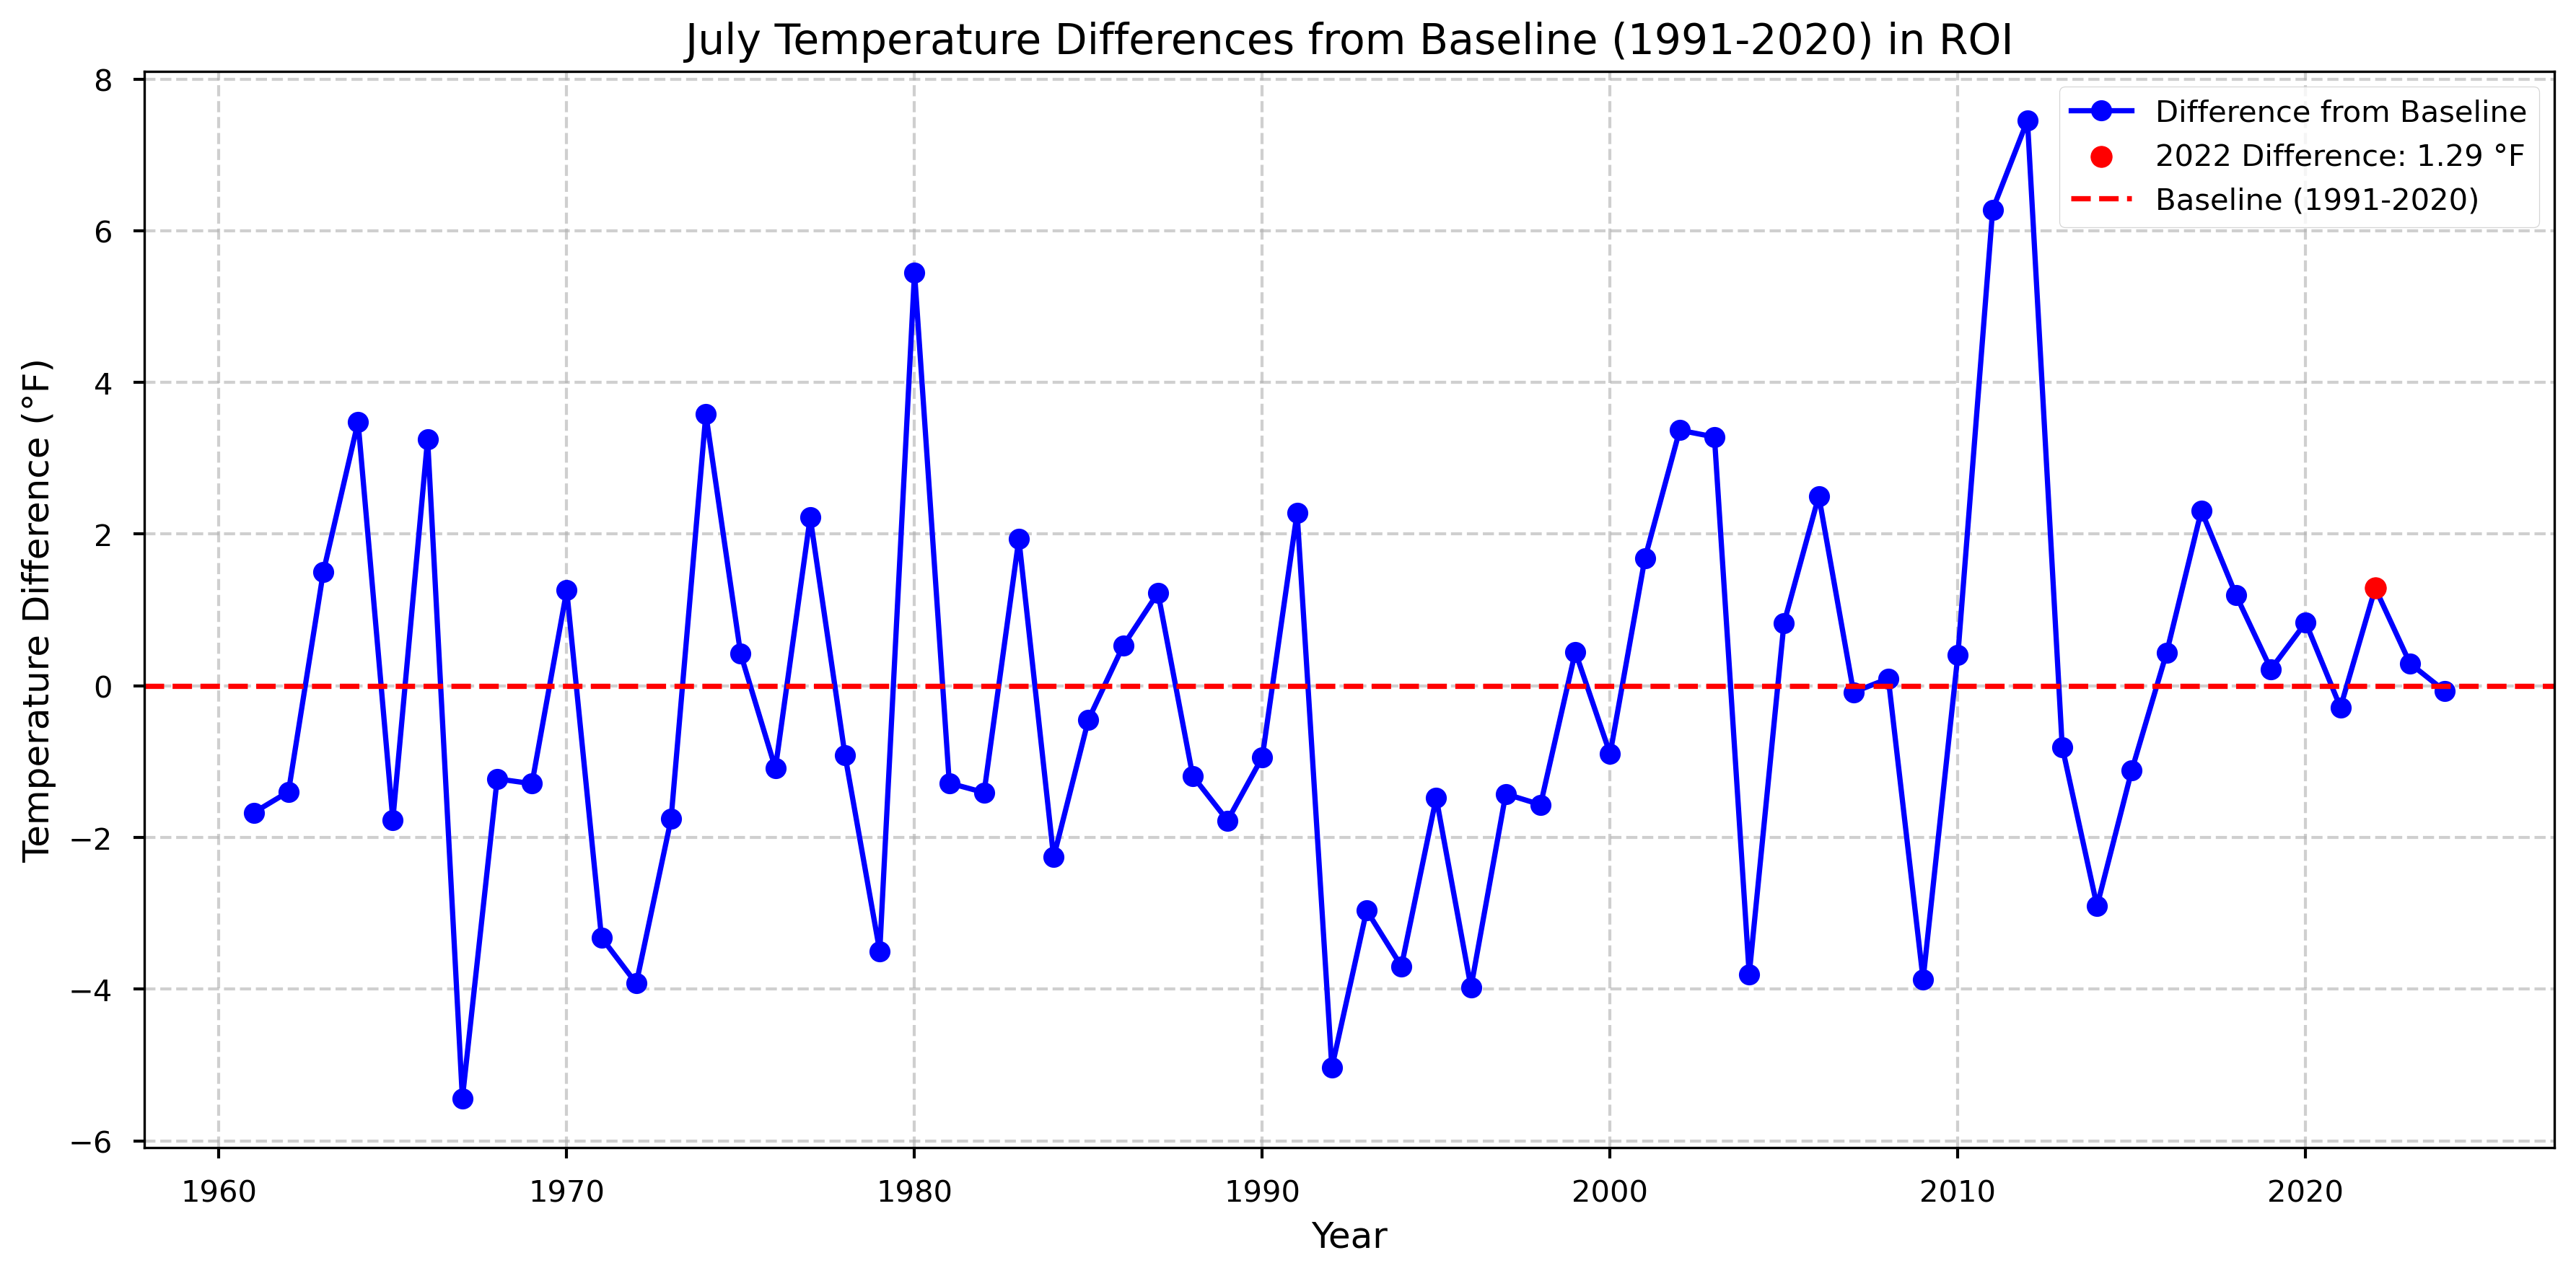

In [74]:
# Plot the differences
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(years, differences, marker='o', linestyle='-', color='b', label='Difference from Baseline')

# Highlight the 2022 value in red
plt.scatter(2022, differences[2022 - start_year], color='r', zorder=5, label=f"2022 Difference: {differences[2022 - start_year]:.2f} °F")

# Baseline (horizontal line at y=0)
plt.axhline(0, color='r', linestyle='--', label='Baseline (1991-2020)')

# Title and labels
plt.title("July Temperature Differences from Baseline (1991-2020) in ROI", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature Difference (°F)", fontsize=12)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

##### Figure 3
July 2022 Temperature Anomaly Relative to 1991–2020 Baseline Average (°F) inside the ROI marked in yellow in Figure 1.

#### Comparison

When comparing the CDS data (Figure 1) and NOAA data (Figure 2), the results are largely consistent, particularly in the red zones (indicating warmer-than-normal areas), where the shapes and intensities of the darkest red regions align closely. However, some differences are noticeable in the blue zones (cooler-than-normal areas), which are fewer and more scattered. For instance, in the yellow-highlighted region in Figure 1, between of Nebraska and Kansas, the NOAA data shows this area as cooler than the 1991–2020 average. In contrast, the ERA5-Land data indicates that the average temperature inside the ROI was slightly above the baseline, specifically by 1.29 °F (Figure 3).

(reanalysis_reanalysis-era5-land-monthly-means_extremes-detection_q02:section-3)=
### 3. Temperature record in Texas
Clip data to the state of Texas and plot the average temperature in this state in July over from 1961.

In [69]:
shapefile_path_tx = "/data/wp5/trigoso_camila/ERA5land/US_states/texas.shp" #Obtained from the US Census Bureau
da_clipped_tx = clip_shapefile(da, shapefile_path_tx)

# Spatial weighted mean
da_spatial_mean_tx = diagnostics.spatial_weighted_mean(da_clipped_tx)

# Convert the xarray DataArray to a DataFrame, keeping only 'forecast_reference_time' and 't2m'
df = da_spatial_mean_tx.to_dataframe(name='t2m').reset_index()

# Keep only the necessary columns
df = df[['forecast_reference_time', 't2m']]

# Convert 'forecast_reference_time' to datetime if it's not already
df['forecast_reference_time'] = pd.to_datetime(df['forecast_reference_time'])

# Filter for July in both periods
df_july = df[df['forecast_reference_time'].dt.month.isin([7])]

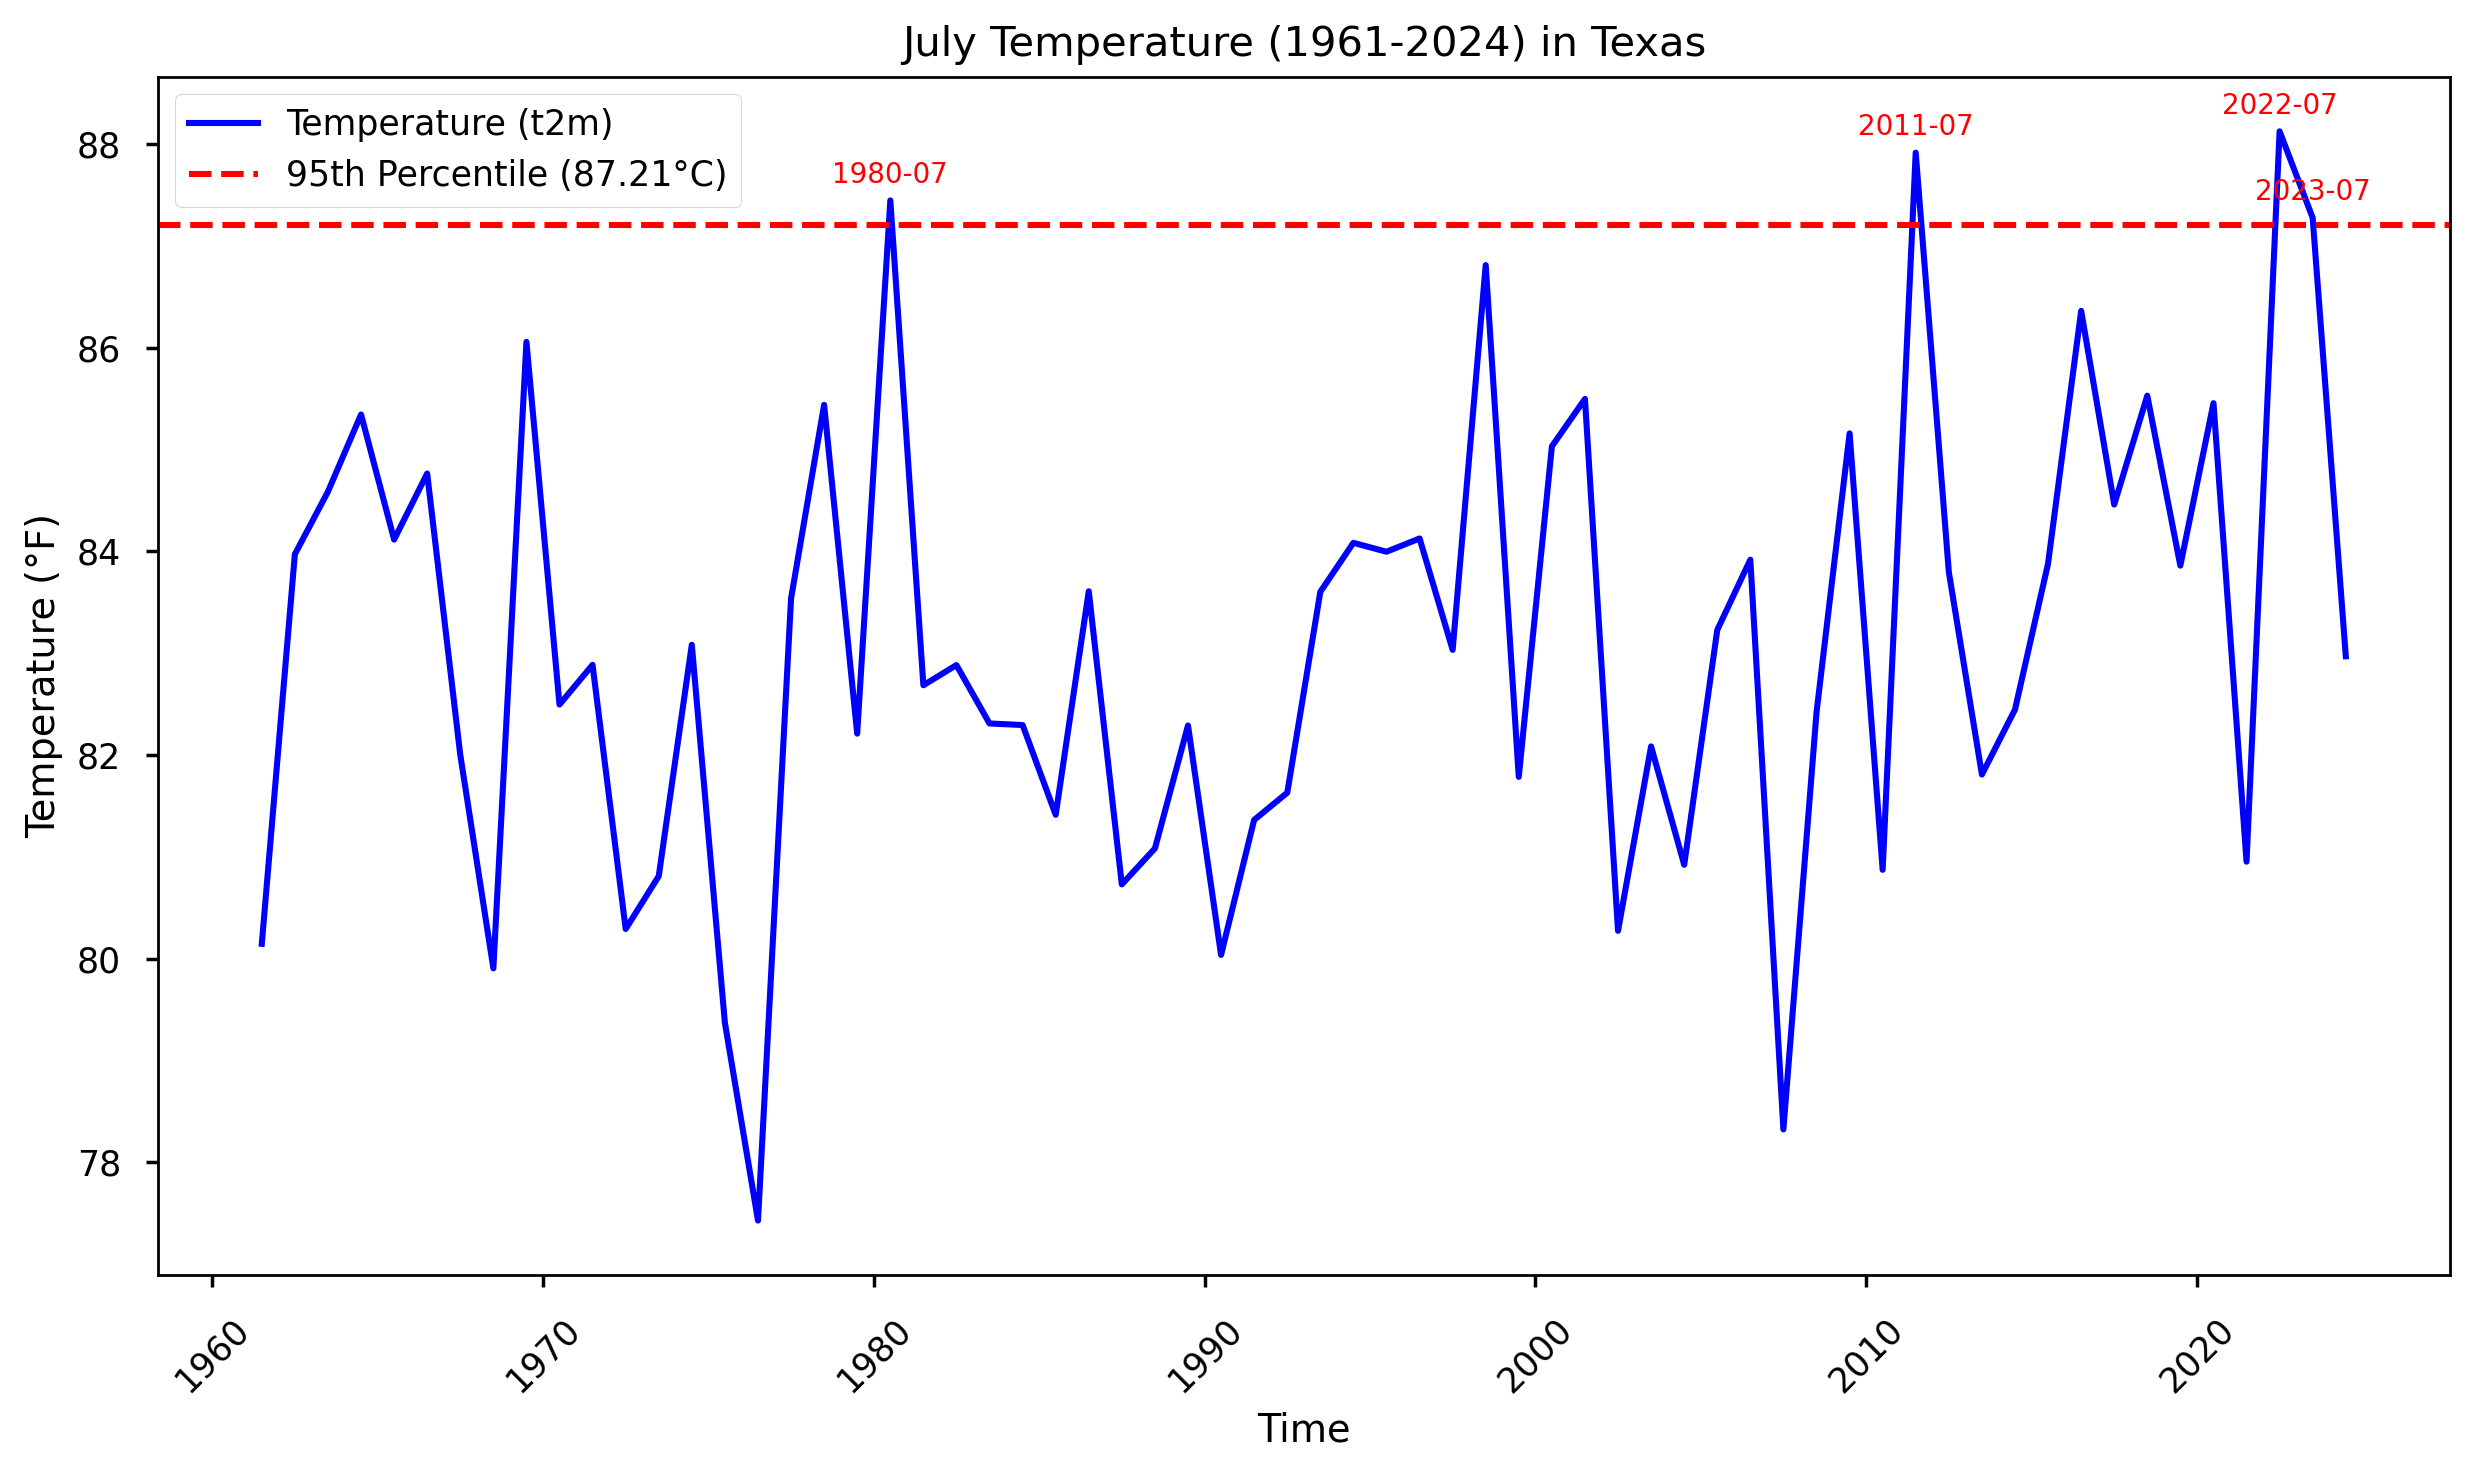

In [42]:
# Calculate the 99th percentile of 't2m' in df_baseline_summer
percentile_95 = df_july['t2m'].quantile(0.95)

# Plot the temperature data
plt.figure(figsize=(10, 6),dpi=250)
plt.plot(df_july['forecast_reference_time'], df_july['t2m'], label='Temperature (t2m)', color='blue')

# Add the horizontal line at the 95th percentile of t2m
plt.axhline(y=percentile_95, color='red', linestyle='--', label=f'95th Percentile ({percentile_95:.2f}°C)')

# Find the points where temperature is above the 99th percentile
above_percentile = df_july[df_july['t2m'] > percentile_95]

# Annotate those points on the plot
for i, row in above_percentile.iterrows():
    plt.annotate(f"{row['forecast_reference_time'].strftime('%Y-%m')}", 
                 (row['forecast_reference_time'], row['t2m']),
                 textcoords="offset points",
                 xytext=(0, 5),  # 5 points vertical offset
                 ha='center', fontsize=8, color='red')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Temperature (°F)')
plt.title('July Temperature (1961-2024) in Texas')

# Show legend
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

#### Figure 3
Historical July Average Temperatures in Texas (°F), 1961–2024

Figure 3 shows that 2022 recorded the highest July temperature in Texas. Other instances of extreme temperatures in July in Texas occurred in 1980, 2011 and 2023. These other three extreme temperature events can also be found in literature [[5]](https://www.twdb.texas.gov/publications/reports/limited_printing/doc/LP-187.pdf), [[6]](https://www.weather.gov/sjt/climate-heatdrought2011), [[7]](https://www.weather.gov/lub/events-2023-2023summer-heat).

In [76]:
val2022 = da_spatial_mean_tx.sel(forecast_reference_time="2022-07-01")
print(f"Texas average 2m temperature in July, 2022: \n{val2022.values:.1f} °F")

val2011 = da_spatial_mean_tx.sel(forecast_reference_time="2011-08-01")
print(f"Texas average 2m temperature in August, 2011: \n{val2011.values:.1f} °F")

Texas average 2m temperature in July, 2022: 
88.1 °F
Texas average 2m temperature in August, 2011: 
89.5 °F


##### Table 1
Average Temperatures in Texas (°F) comparison

| Date   |  CDS dataset T(°F) | NOAA T(°F) [[2]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202207)   | Difference T(°F)  |
|---------------|-------------------------------------|----------------------|--------------|
| July, 2022    | 88.1                               | 87.3                 | 0.8          |
| August, 2011  | 89.5                               | 88.2                 | 1.3          |

#### Comparison
According to NOAA's national monthly report for July 2022 [[2]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202207), July 2022 was the second warmest month recorded, with an average temperature of 87.3 °F, surpassed only by August 2011, when the temperature reached 88.2 °F. In contrast, according to the CDS data, the average July temperature in 2022 in the state of Texas was 88.1 °F, 0.8 °F higher than the NOAA-reported value. As presented in Table 1, the temperature in August 2011 is also different by 1.3 °F.

#### Analysis

ERA5-Land provides valuable insights into temperature anomalies, especially for periods or regions with limited or no data available. In this study, we focused on the USA, where we could compare ERA5-Land data with official sources like NOAA. The results show some discrepancies between the ERA5-Land data and the NOAA's published information. However, these differences are generally small, as shown in Table 1. It is important to note that, as explained under Figure 2, NOAA uses in situ measurements and interpolates for regions without data. This interpolation process could introduce its own errors. Given these uncertainties, the relatively small discrepancies between ERA5-Land and NOAA data serve as a positive indicator of ERA5-Land’s effectiveness. Overall, ERA5-Land proves to be a reliable resource for monitoring and analyzing temperature extremes, despite the small errors when compared to official sources.

The ERA5-Land documentation mentions that the dataset is primarily based on the Tiled ECMWF Scheme for Surface Exchanges over Land (H-TESSEL), which uses version CY45R1 of the ECMWF Integrated Forecasting System (IFS). Including a brief explanation of how this system works in the documentation would be helpful for users to make a quick comparison with other datasets.

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation) CDS (2024). ERA5-Land: data documentation. CDS.

[[2]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202207) National Centers for Environmental Information (2022). July 2022 National Climate Report. NOAA

[[3]](https://www.climate.gov/data/Temperature--Monthly--Difference-from-average--CONUS/01-small/Temperature--Monthly--Difference-from-average--CONUS--2022-07-00--small.png) NOAA Climate (2023). Temperature--Monthly--Difference-from-average--CONUS--2022-07-00--small.png.	

[[4]](https://www.climate.gov/maps-data/data-snapshots/data-source/temperature-us-monthly-difference-average) NOAA Climate (2024). Temperature - US Monthly, Difference from Average.

[[5]](https://www.twdb.texas.gov/publications/reports/limited_printing/doc/LP-187.pdf) Bomar, G. (1983). 1980: When scorching heat gripped Texas. Texas Department of Water Resources.

[[6]](https://www.weather.gov/sjt/climate-heatdrought2011) National Weather Service (2011). The Heat and Drought of 2011.

[[7]](https://www.weather.gov/lub/events-2023-2023summer-heat) National Weather Service (2023). Exceptional Heat of Summer 2023.